# Loading the dataset and importing libraries


In [ ]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from numpy import fft
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

from app import EvaluateAndReport, add_features, plot_features

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

#returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

Mounted at /content/drive


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [ ]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


# Data treatment

In [ ]:
# Train/test split
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [ ]:
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


In [ ]:
naive_base = X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

In [ ]:
# splitting the bands into single elements
df = df.join(naive_base)

In [ ]:
df.head()

,id,band_1,band_2,inc_angle,is_iceberg,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,band_1_8,band_1_9,band_1_10,band_1_11,band_1_12,band_1_13,band_1_14,band_1_15,band_1_16,band_1_17,band_1_18,band_1_19,band_1_20,band_1_21,band_1_22,band_1_23,band_1_24,band_1_25,band_1_26,band_1_27,band_1_28,band_1_29,band_1_30,band_1_31,band_1_32,band_1_33,band_1_34,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
530,f06ecb96,"[-22.622971, -19.042347, -18.257372, -18.69734...","[-23.36264, -22.62306, -23.962086, -24.38596, ...",30.4878,1,-22.622971,-19.042347,-18.257372,-18.697346,-20.440437,-20.440529,-16.872957,-18.697704,-17.637222,-14.771990,-15.064069,-18.366076,-18.698151,-19.281404,-18.366344,-17.058575,-19.281673,-21.310917,-18.698689,-17.738623,-20.305080,-19.526810,-18.047298,-16.874477,-17.153282,-17.840750,-17.441418,-16.604786,-17.153641,-17.739517,-17.441776,-16.694231,-15.368186,-14.774137,-16.694500,...,-24.389721,-23.366758,-21.313601,-22.627266,-24.390078,-21.945848,-24.390257,-22.280142,-21.314140,-20.868700,-22.111748,-24.836233,-24.610701,-23.762714,-21.784298,-21.314764,-22.112286,-24.176765,-23.368282,-23.967636,-26.605476,-23.967815,-26.062611,-25.551620,-22.453671,-23.763790,-25.803671,-24.392139,-23.968441,-22.282114,-21.948090,-22.282293,-24.178108,-24.392677,-22.992010,-22.282654,-22.282743,-23.764866,-25.308275,-23.969429
1140,974931df,"[-27.235119, -26.907366, -24.170664, -24.17072...","[-32.01276, -29.514042, -26.907423, -29.090368...",38.4591,1,-27.235119,-26.907366,-24.170664,-24.170721,-24.653395,-23.279133,-29.959793,-27.930696,-27.930754,-22.865665,-20.727779,-19.972065,-25.432146,-28.686749,-25.432259,-24.409208,-22.666262,-26.908094,-24.171391,-21.556082,-20.887661,-20.887661,-23.279917,-25.993223,-25.993280,-23.070776,-23.070776,-23.494617,-25.708639,-27.577129,-30.927008,-30.430592,-30.430592,-25.433098,-26.908876,...,-27.934340,-31.456221,-29.094288,-29.094288,-29.094345,-29.518187,-27.580044,-25.711666,-26.911680,-29.094570,-28.304455,-29.963997,-28.304567,-29.518581,-29.518581,-29.094851,-29.094906,-32.017525,-31.457005,-30.434010,-32.017635,-34.711662,-27.935349,-25.997204,-27.240219,-29.095299,-28.691288,-25.436798,-24.910276,-28.305351,-28.691511,-29.964893,-29.095634,-27.581276,-27.935907,-29.965117,-29.095804,-28.305687,-29.095917,-30.931379
168,d6566373,"[-28.63821, -26.238758, -29.042387, -29.042442...","[-25.944237, -25.659485, -28.252216, -31.40442...",39.5048,0,-28.638210,-26.238758,-29.042387,-29.042442,-25.944458,-25.944511,-27.528191,-27.187578,-29.042713,-29.466555,-29.912138,-31.965439,-36.402470,-36.402470,-33.208508,-30.381977,-28.252926,-27.188070,-25.945168,-26.860371,-27.883476,-29.467155,-29.467211,-27.188398,-27.188452,-28.253418,-28.639574,-28.639574,-30.879105,-28.639683,-28.253635,-28.253691,-25.945875,-25.945930,-27.529612,...,-28.255329,-30.384491,-26.862720,-26.546890,-26.862829,-27.190638,-28.641705,-29.915142,-28.641815,-27.886101,-28.255823,-27.531633,-27.531689,-27.191076,-25.663364,-24.609291,-27.191238,-29.915688,-29.915688,-29.046431,-29.046486,-29.915852,-31.969154,-33.212170,-31.408689,-27.886921,-29.046812,-28.256699,-26.243347,-26.548203,-27.191952,-25.121138,-26.243513,-28.643074,-29.916512,-31.409237,-32.569130,-27.887520,-24.127768,-25.664623
135,6706ea46,"[-22.52327, -20.36145, -18.631905, -19.001574,...","[-26.236002, -27.819691, -25.408276, -25.14897...",36.1091,1,-22.523270,-20.361450,-18.631905,-19.001574,-19.257124,-18.753517,-21.974827,-20.661316,-20.215853,-19.388000,-21.131067,-21.458941,-19.93123

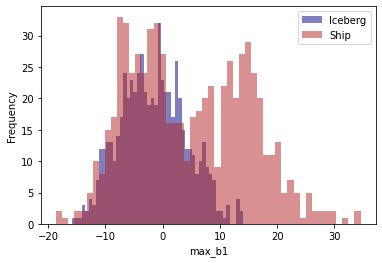

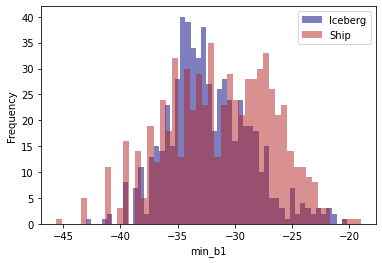

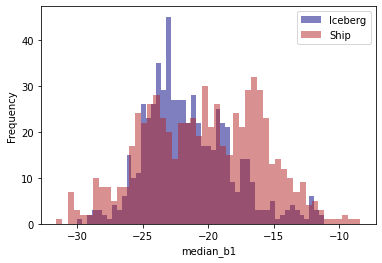

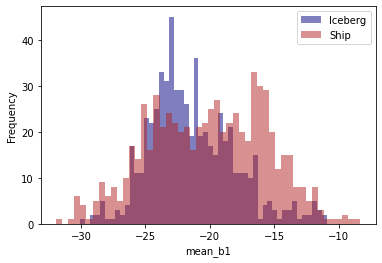

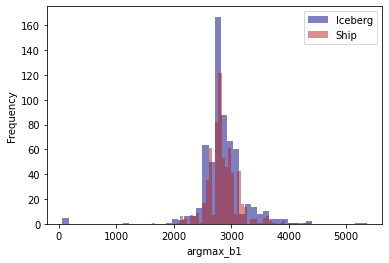

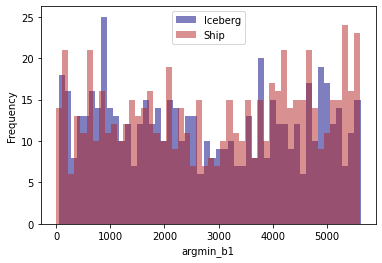

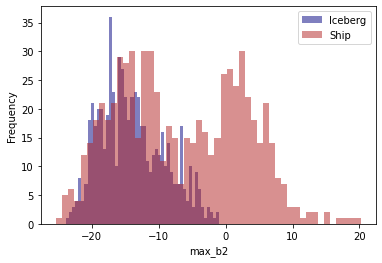

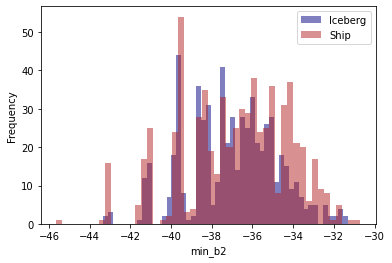

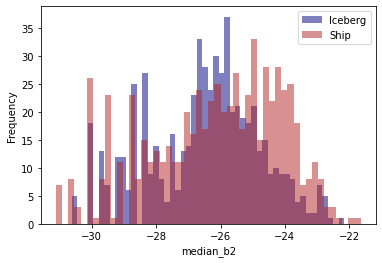

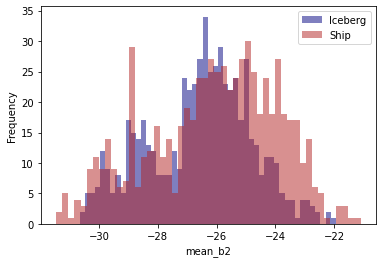

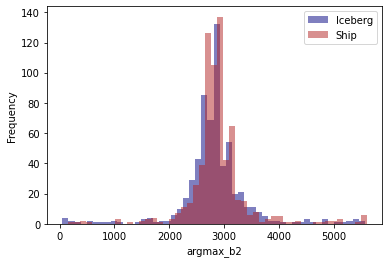

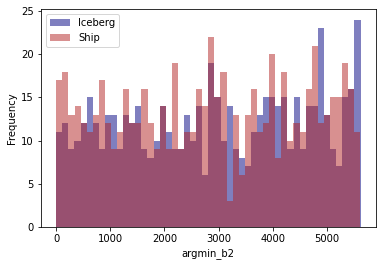

In [ ]:
# applying the above function 
df = add_features(df,1)
df = add_features(df,2)

# plotting the variables
for i in [1,2] :
  for col in ['max_b'+str(i),'min_b'+str(i),'median_b'+str(i),'mean_b'+str(i),'argmax_b'+str(i),'argmin_b'+str(i)]:
    plot_features(df, col)

## Matrice de corrélation

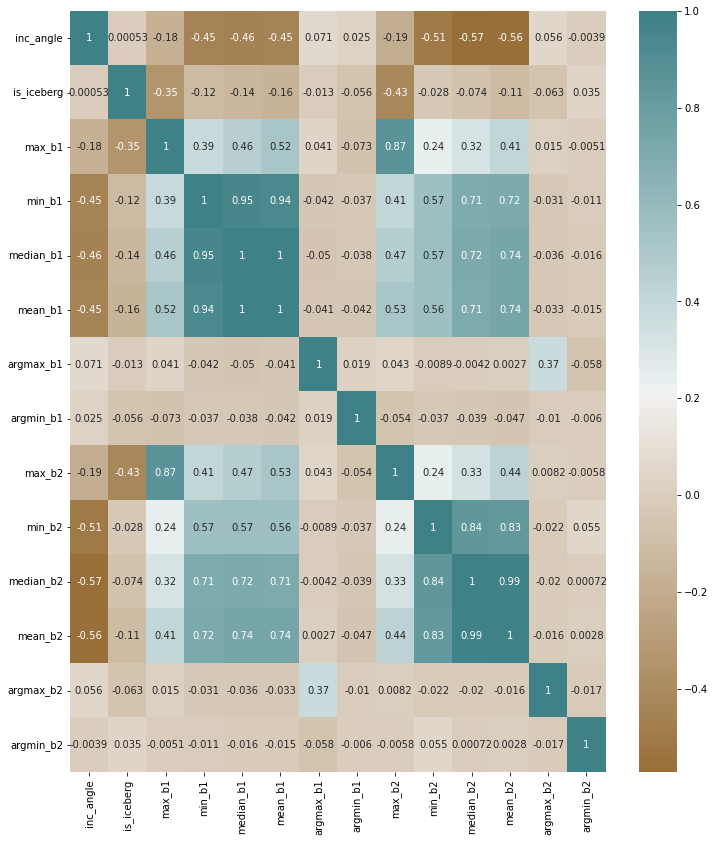

In [ ]:
stats_corr = df.drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).corr()
plt.figure(figsize = (12,14))
ax = sns.heatmap(stats_corr, annot = True, cmap = sns.diverging_palette(50, 200, n=200))

# Results

## On statistics only

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

# selecting the prediction target and the model features
y = df["is_iceberg"]
X_stats = df.loc[:,['max_b1','min_b1','median_b1','mean_b1','argmax_b1','argmin_b1','max_b2','min_b2','median_b2','mean_b2','argmax_b2','argmin_b2']]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)

### DecisionTreeClassifier

In [ ]:
X_stats

,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2
530,-0.897075,-29.583092,-18.048462,-18.112508,2667,4169,-14.703813,-31.325020,-22.802425,-22.830266,2741,4083
1140,-5.598961,-36.454388,-26.289146,-26.294448,2888,4634,-23.071953,-38.634918,-29.091711,-29.087352,51,1090
168,-8.369424,-39.927570,-27.886208,-28.104746,3124,4853,-17.648048,-39.926807,-28.255713,-28.530522,3198,1629
135,-6.444110,-31.174166,-19.936411,-20.070621,2732,2541,-18.755909,-36.697906,-26.532661,-26.580998,2205,899
438,8.382858,-31.131157,-20.250298,-19.967787,3187,258,-2.915977,-39.649490,-27.980453,-27.961630,3187,2931
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,-6.607138,-38.072559,-22.509045,-22.704236,2735,4866,-18.322495,-33.390518,-24.604317,-24.899377,4667,4332
16,-8.202933,-34.144661,-23.608482,-23.678953,2960,4319,-18.849331,-36.909927,-25.145733,-25.384818,5527,3175
1072,-7.761281,-39.508995,-28.626736,-28.777052,2974,3448,-12.464365,-43.029026,-29.050724,-29.288303,2974,340
1579,-9.798533,-30.373240,-18.104858,-18.139073,2885,41,-13.804255,-36.862823,-25.579882,-25.782242,2735,4743


--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.678
--- Cross Validation Report ---
Mean accuracy score 0.695 with std 0.025
Mean f1 score 0.671 with std 0.023
Mean precision score 0.685 with std 0.035
Mean recall score 0.658 with std 0.028
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.707
 f1 : 0.701
 precision : 0.701
 recall : 0.701
Confusion matrix for the test sample :


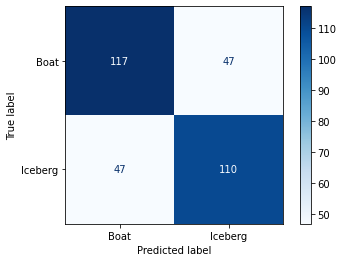

In [ ]:
df_stats = df.loc[:,['id','is_iceberg','inc_angle','is_iceberg','max_b1','min_b1','median_b1','mean_b1','argmax_b1','argmin_b1','max_b2','min_b2','median_b2','mean_b2','argmax_b2','argmin_b2']]
er = EvaluateAndReport(df_stats, X_train, X_test, y_train, y_test)

param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)

In [ ]:
er.cross_proba_report()

--- Cross Validation with 0.5 Threshold Report ---
 accuracy : 0.698
 f1 : 0.695
 precision : 0.661
 recall : 0.733


--- Precision Recall Curves ---


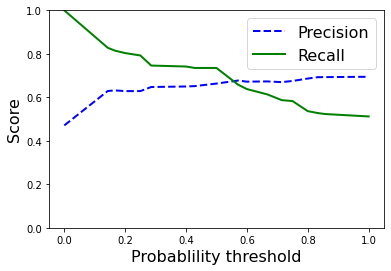

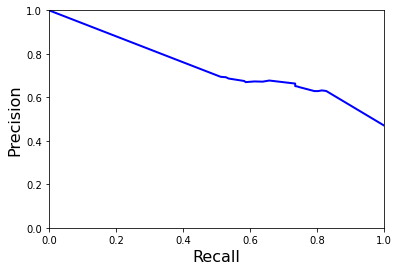

In [ ]:
er.plot_precision_recall()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') :
 {'n_neighbors': 12} with f1 score 0.367
--- Cross Validation Report ---
Mean accuracy score 0.535 with std 0.007
Mean f1 score 0.38 with std 0.018
Mean precision score 0.511 with std 0.012
Mean recall score 0.302 with std 0.019
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.505
 f1 : 0.367
 precision : 0.489
 recall : 0.293
Confusion matrix for the test sample :


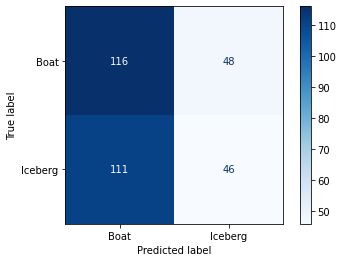

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)

## On PCA data only

In [ ]:
# Applying a PCA and saving for differents PCs

# I could have used a pipeline...
def get_pca_df(df, X, pcs):
  X_std = StandardScaler().fit_transform(X)
  pca = PCA(pcs).fit(X_std)
  res = pd.DataFrame(pca.transform(X_std),columns=['PC%s' % _ for _ in range(pcs)], index=df.index)
  res = res.join(df['is_iceberg'])
  res = res.dropna()
  return res

In [ ]:
pca_5 = get_pca_df(df, naive_base, 5)
pca_10 = get_pca_df(df, naive_base, 10)
pca_20 = get_pca_df(df, naive_base, 20)
pca_50 = get_pca_df(df, naive_base, 50)
pca_100 = get_pca_df(df, naive_base, 100)
pca_200 = get_pca_df(df, naive_base, 200)
pca_500 = get_pca_df(df, naive_base, 500)

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.619
--- Cross Validation Report ---
Mean accuracy score 0.673 with std 0.04
Mean f1 score 0.639 with std 0.046
Mean precision score 0.667 with std 0.051
Mean recall score 0.618 with std 0.061
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.651
 f1 : 0.643
 precision : 0.643
 recall : 0.643
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, crite

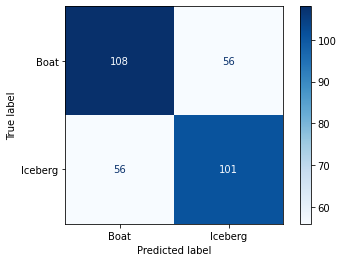

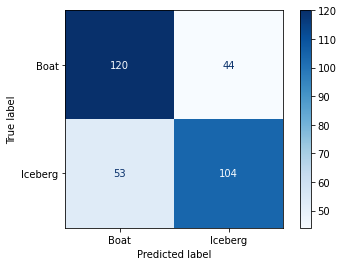

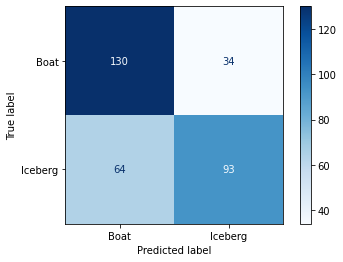

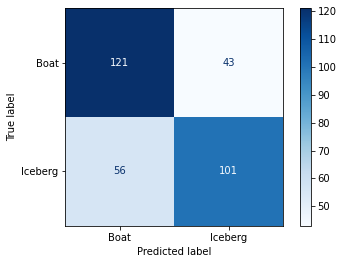

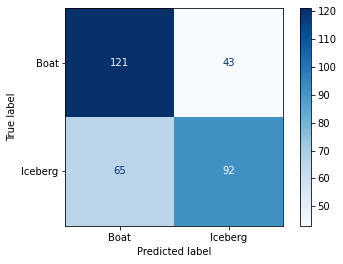

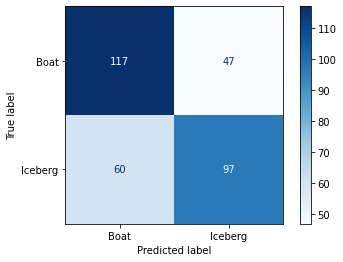

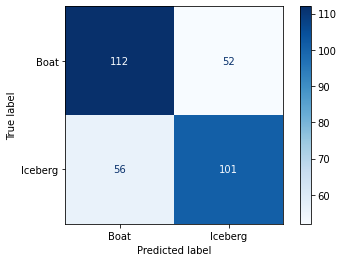

In [ ]:
param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 3

train_scores = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores.append(er.best_scores_t)

In [ ]:
train_scores

[{'accuracy': 0.673, 'f1': 0.639, 'precision': 0.667, 'recall': 0.618},
 {'accuracy': 0.689, 'f1': 0.658, 'precision': 0.678, 'recall': 0.642},
 {'accuracy': 0.686, 'f1': 0.658, 'precision': 0.675, 'recall': 0.645},
 {'accuracy': 0.705, 'f1': 0.686, 'precision': 0.691, 'recall': 0.684},
 {'accuracy': 0.663, 'f1': 0.636, 'precision': 0.646, 'recall': 0.627},
 {'accuracy': 0.664, 'f1': 0.631, 'precision': 0.654, 'recall': 0.611},
 {'accuracy': 0.636, 'f1': 0.6, 'precision': 0.619, 'recall': 0.585}]

In [ ]:
x_plot = [5, 10, 20, 50, 100, 200, 500]
y_plot1 = [a.get('accuracy') for a in train_scores]
y_plot2 = [a.get('f1') for a in train_scores]
y_plot3 = [a.get('precision') for a in train_scores]
y_plot4 = [a.get('recall') for a in train_scores]

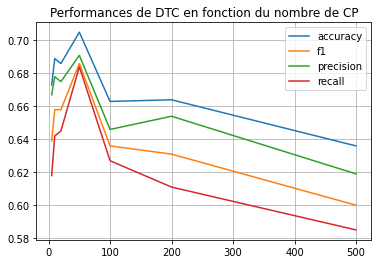

In [ ]:
plt.plot(x_plot, y_plot1, label='accuracy')
plt.plot(x_plot, y_plot2, label='f1')
plt.plot(x_plot, y_plot3, label='precision')
plt.plot(x_plot, y_plot4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') :
 {'n_neighbors': 16} with f1 score 0.677
--- Cross Validation Report ---
Mean accuracy score 0.684 with std 0.03
Mean f1 score 0.682 with std 0.035
Mean precision score 0.649 with std 0.03
Mean recall score 0.722 with std 0.067
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.701
 f1 : 0.711
 precision : 0.674
 recall : 0.752
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') :
 {'n_neighbors': 8} with f1 score 0.709
--- Cross Validation Report ---
Mean accuracy score 0.731 with std 0.037
Mean f1 score 0.715 with st

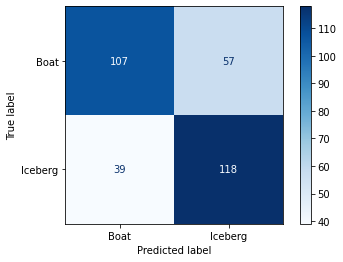

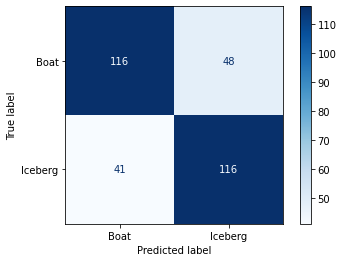

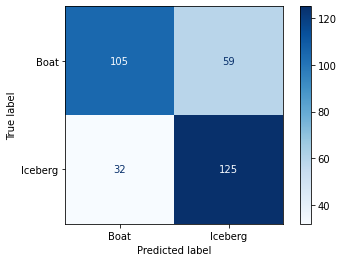

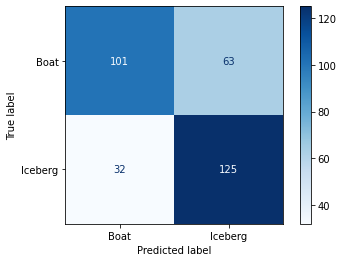

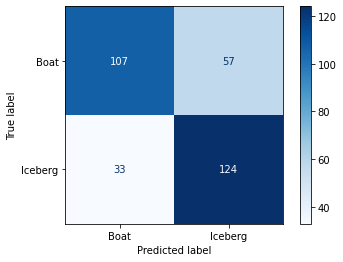

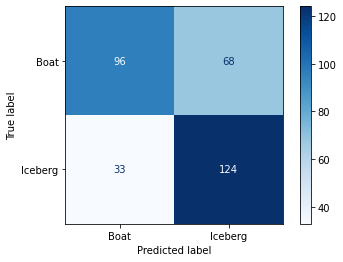

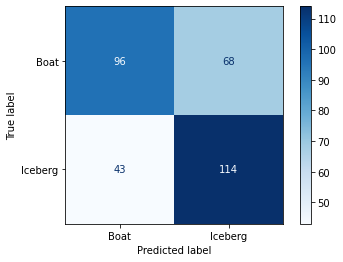

In [ ]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3

train_scores_knn = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

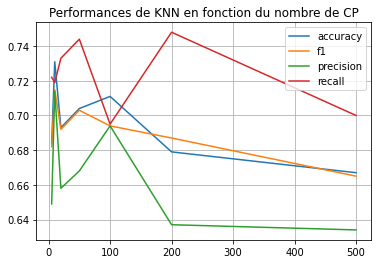

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

## On PCA and statistics

In [56]:
df_stats = df_stats.loc[:,~df_stats.columns.duplicated()]
df_5 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_5.drop('is_iceberg',axis=1)).dropna()
df_20 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_20.drop('is_iceberg',axis=1)).dropna()
df_50 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_50.drop('is_iceberg',axis=1)).dropna()
df_100 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_100.drop('is_iceberg',axis=1)).dropna()

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.704
--- Cross Validation Report ---
Mean accuracy score 0.74 with std 0.059
Mean f1 score 0.719 with std 0.066
Mean precision score 0.734 with std 0.067
Mean recall score 0.707 with std 0.078
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.72
 f1 : 0.713
 precision : 0.713
 recall : 0.713
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criter

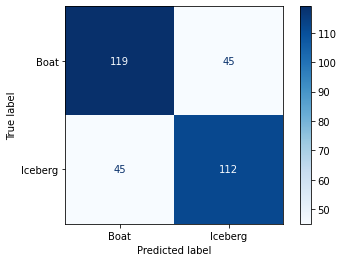

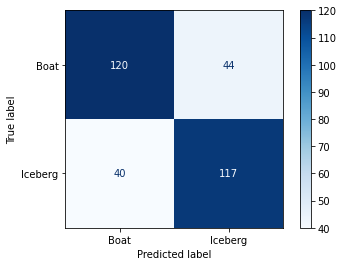

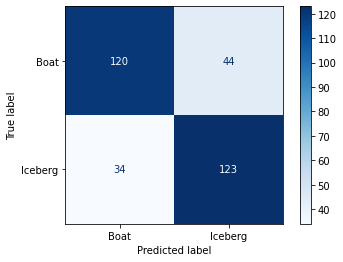

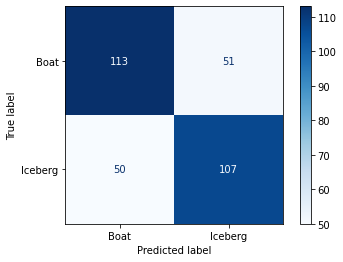

In [60]:
train_scores_mix = []
for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop(['is_iceberg'],axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores_mix.append(er.best_scores_t)

In [61]:
x_p = [5, 20, 50, 100]
y1 = [a.get('accuracy') for a in train_scores_mix]
y2 = [a.get('f1') for a in train_scores_mix]
y3 = [a.get('precision') for a in train_scores_mix]
y4 = [a.get('recall') for a in train_scores_mix]

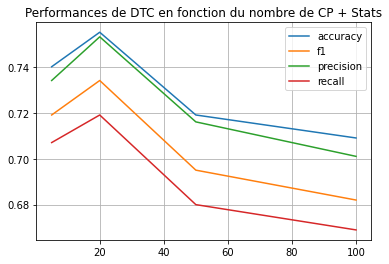

In [62]:
plt.plot(x_p, y1, label='accuracy')
plt.plot(x_p, y2, label='f1')
plt.plot(x_p, y3, label='precision')
plt.plot(x_p, y4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP + Stats')
plt.grid(True)
plt.show()